In [1]:
import pandas as pd

# Data Loading

In [2]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'])

# Number of different Datasets
datasets_number = 3

# Lists of DataFrames
df_train : list[pd.DataFrame] = []
df_test  : list[pd.DataFrame] = []

# Load the Training/Test sets into pandas DataFrames
for i in range(datasets_number):
    df_train.append(data_handler.load_data(f'data/monks/monks-{i+1}.train'))
    df_test.append(data_handler.load_data(f'data/monks/monks-{i+1}.test'))

    # Print the head of the loaded data
    print(df_train[i].head())
    print(df_test[i].head())

     target  col1  col2  col3  col4  col5  col6       id
NaN       1     1     1     1     1     3     1   data_5
NaN       1     1     1     1     1     3     2   data_6
NaN       1     1     1     1     3     2     1  data_19
NaN       1     1     1     1     3     3     2  data_22
NaN       1     1     1     2     1     2     1  data_27
     target  col1  col2  col3  col4  col5  col6      id
NaN       1     1     1     1     1     1     1  data_1
NaN       1     1     1     1     1     1     2  data_2
NaN       1     1     1     1     1     2     1  data_3
NaN       1     1     1     1     1     2     2  data_4
NaN       1     1     1     1     1     3     1  data_5
     target  col1  col2  col3  col4  col5  col6       id
NaN       0     1     1     1     1     2     2   data_4
NaN       0     1     1     1     1     4     1   data_7
NaN       0     1     1     1     2     1     1   data_9
NaN       0     1     1     1     2     1     2  data_10
NaN       0     1     1     1     2  

# Data Split

In [3]:
# Lists of data
x_train : list[pd.DataFrame] = []
y_train : list[pd.DataFrame] = []
x_test  : list[pd.DataFrame] = []
y_test  : list[pd.DataFrame] = []

# Split data into TR set and TS set
for i in range(datasets_number):

    # Saving the splitted TR set data into the lists
    x, y = data_handler.split_data(data=df_train[i], target_col='target', drop_cols=['target', 'id'])
    x_train.append(x)
    y_train.append(y)

    # Saving the splitted TS set data into the lists
    x, y = data_handler.split_data(df_test[i], target_col='target', drop_cols=['target', 'id'])
    x_test.append(x)
    y_test.append(y)


# 1-Hot Encoding

In [4]:
# Applies the 1-Hot Encoding to the "x" data
for i in range(datasets_number):
    x_train[i] = data_handler.one_hot_encoding(x_train[i])
    x_test[i]  = data_handler.one_hot_encoding(x_test[i])

    # Print of the data modified
    print(f"Monk {i+1} [TRAIN]: " + str(x_train[i].shape))
    print(f"Monk {i+1} [TEST]: " + str(x_test[i].shape))

Monk 1 [TRAIN]: (124, 17)
Monk 1 [TEST]: (432, 17)
Monk 2 [TRAIN]: (169, 17)
Monk 2 [TEST]: (432, 17)
Monk 3 [TRAIN]: (122, 17)
Monk 3 [TEST]: (432, 17)


# Grid Search parameters

In [5]:
# Parameters' space for Grid Search (1 for each Dataset)
param_space = {
       0: {
        'input_units': [17],
        'hidden_units': [3, 4, 5],
        'patience': [10,15,30],
        'learning_rate': [0.01, 0.2, 0.3, 0.4, 0.5],
        'batch_size': [4, 16, 32, 64],
        'nesterov': ["T", "F"],
        'epochs': [int(350+epochs) for epochs in range(0,200,10)],
        'momentum': [float(i/10) for i in range(3,10)],
        'activation': ['tanh'],
        'output_activation': ['sigmoid'],
        'metrics': ['accuracy'],
    },
    1: {
        'input_units': [17],
        'hidden_units': [3, 4, 5],
        'patience': [10,100,200],
        'factor_lr_dec': [0.5, 1],
        'step_decay': [500, 1000, 1500],
        'learning_rate': [float(i/100) for i in range(1,101,5)] + [0.999, 0.9999],
        'batch_size': [10, 15, 30, 60], # 169 ROWS
        'epochs': [int(250+epochs) for epochs in range(0,200,20)],
        'momentum': [float(i/100) for i in range(50,90,5)],
        'nesterov': ["T", "F"],
        'activation': ['tanh'],
        'output_activation': ['sigmoid'],
        'metrics': ['accuracy'],
    },
    2: {
        'input_units': [17],
        'hidden_units': [2, 3],
        'patience': [10,15,30],
        'factor_lr_dec': [0.5, 1],
        'step_decay': [500, 1000, 1500],
        'learning_rate': [float(i/100) for i in range(1,10)],
        'batch_size': [7, 8, 9, 32, 64],
        'epochs': [int(350+epochs) for epochs in range(0,50,10)],
        'weight_decay': [float(i/1000) for i in range(1,10)],
        'momentum': [float(i/1000) for i in range(10,90,5)] + [float(i/100) for i in range(10,90,5)],
        'nesterov': ["T", "F"],
        'activation': ['tanh'],
        'output_activation': ['sigmoid'],
        'metrics': ['accuracy'],
    }
}

# Model Selection

## Best Hyperparameters Research

In [6]:
from sklearn.model_selection import StratifiedKFold
from api.binary_nn import BinaryNN

# Creation of a BinaryNN objct for each dataset
nn: list[BinaryNN] = []

# Different values per dataset
trials_list = [1, 1, 40] #40, 30
k_values = [5, 5, 5]
n_hidden_layers_list = [1, 1, 1]

# Search of the best Hyperparameters to each Training set
for dataset_i in range(datasets_number):
    X = x_train[dataset_i].values
    y = y_train[dataset_i].values
    k = k_values[dataset_i]

    # K-fold Cross-validation
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # For each iteration we choose the hyperparameters (randomly) and we use them with K-fold CV
    for i in range(trials_list[dataset_i]):
        #if i != 2:
        #    continue
        
        # Random parameters
        params = data_handler.random_dictionary(param_space[dataset_i])

        # Creation of the Neural Network object
        nn_i = BinaryNN(params=params, monk_i=dataset_i+1, trial=i+1)

        # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
        for train_index, val_index in kfold.split(X, y):
            x_kfold_train, x_kfold_val = X[train_index], X[val_index]
            y_kfold_train, y_kfold_val = y[train_index], y[val_index]

            # Building the model
            nn_i.create_model(n_hidden_layers=n_hidden_layers_list[dataset_i])

            # Training the model
            nn_i.fit(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

            # Evaluating the model
            nn_i.evaluate(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

        # Case of first append
        if len(nn) == dataset_i:
            nn.append(nn_i)
        
        # Print the results of this trial
        print("------------------ Current Hyperparameters ------------------")
        nn_i.print_training_info()
        print("-------------------- Best Hyperparameters -------------------")
        nn[dataset_i].print_training_info()
        print("\n\n")

        # Update best hyperparameters if: no high overfitting AND (higher mean VL accuracy OR (equal mean AND
        if nn_i.mean_tr_accuracy-0.1 <= nn_i.mean_vl_accuracy \
            and (
                    nn[dataset_i].mean_vl_accuracy < nn_i.mean_vl_accuracy \
                or (
                    nn[dataset_i].mean_vl_accuracy == nn_i.mean_vl_accuracy and nn[dataset_i].mean_tr_accuracy < nn_i.mean_tr_accuracy
                    )
            ):
            nn[dataset_i] = nn_i
        
        # Case of TR/VL accuracy = 1.0 AND TR/VL loss minor
        if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy >= 1 \
            and nn_i.mean_tr_accuracy == nn[dataset_i].mean_tr_accuracy \
            and nn_i.mean_vl_accuracy == nn[dataset_i].mean_vl_accuracy \
            and abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < 0.02 \
            and nn_i.mean_vl_loss < nn[dataset_i].mean_vl_loss \
            and nn_i.mean_tr_loss < nn[dataset_i].mean_tr_loss:
            nn[dataset_i] = nn_i
        
        # Exit case
        if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy == 1 \
            and nn_i.mean_vl_loss < 0.1 and nn_i.mean_tr_loss < 0.1 \
            and abs(nn_i.mean_vl_loss - nn_i.mean_tr_loss) < 0.01:
            nn[dataset_i] = nn_i
            break

    # Print output
    print(f"### Best Hyperparameters of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    print("\n\n")






------------------ Current Hyperparameters ------------------
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 64, 'nesterov': 'T', 'epochs': 480, 'momentum': 0.6, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.016374582186108454
 Mean Validation Loss:     0.05057988176122308
 Mean Training Accuracy:   0.9838383793830872
 Mean Validation Accuracy: 0.9519999980926513
-------------------- Best Hyperparameters -------------------
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 64, 'nesterov': 'T', 'epochs': 480, 'momentum': 0.6, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.016374582186108454
 Mean Validation Loss:   

## Print of best Hyperparameters and Plots


### Best Hyperparameters for Monk 1 ###
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 64, 'nesterov': 'T', 'epochs': 480, 'momentum': 0.6, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.016374582186108454
 Mean Validation Loss:     0.05057988176122308
 Mean Training Accuracy:   0.9838383793830872
 Mean Validation Accuracy: 0.9519999980926513

### Best Hyperparameters for Monk 2 ###
 Monk:                     2
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.21, 'batch_size': 30, 'epochs': 270, 'momentum': 0.5, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.06516014821827412
 Mean Validation Loss:     0.

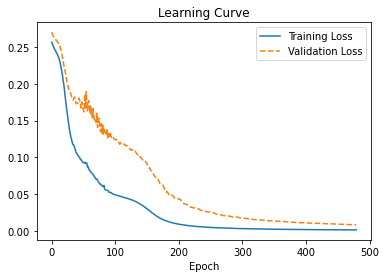

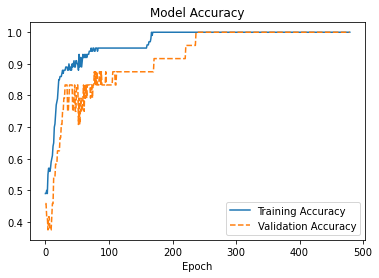

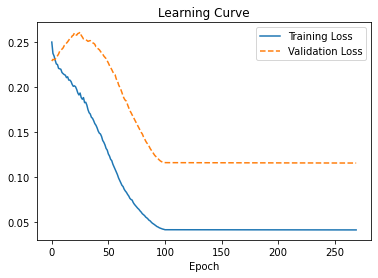

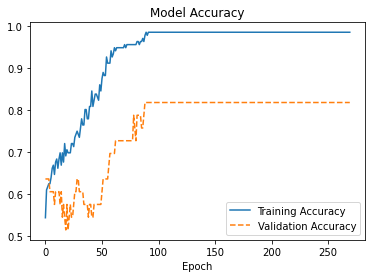

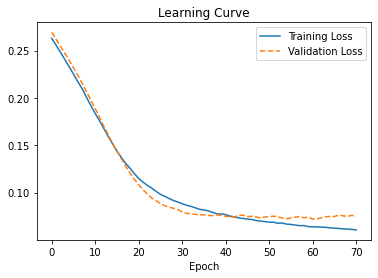

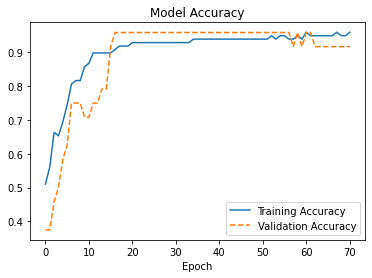

In [7]:
# Iteration on all the Datasets
for dataset_i in range(datasets_number):

    # Print best hyperparameters
    print(f"\n### Best Hyperparameters for Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()

    # Plot the learning curve
    nn[dataset_i].print_plot()   

    # Hyperparameters:   monk1   {'input_units': 17, 'hidden_units': 4, 'patience': 100, 'learning_rate': 0.4, 'batch_size': 15, 'epochs': 380, 'weight_init': 'he_normal', 'momentum': 0.7, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    #  Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'patience': 200, 'learning_rate': 0.8, 'batch_size': 15, 'epochs': 380, 'weight_init': 'he_uniform', 'momentum': 0.6, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    #  Hyperparameters:          {'input_units': 17, 'hidden_units': 2, 'patience': 10, 'factor_lr_dec': 1.0, 'step_decay': 1500, 'learning_rate': 0.06, 'batch_size': 65, 'epochs': 360, 'weight_decay': 0.8, 'weight_init': 'glorot_normal', 'momentum': 0.2, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}

   # l curve buona con:
   # Hyperparameters:  monk1        {'input_units': 17, 'hidden_units': 5, 'patience': 100, 'factor_lr_dec': 1.0, 'step_decay': 1500, 'learning_rate': 0.99, 'batch_size': 15, 'epochs': 360, 'weight_init': 'glorot_normal', 'momentum': 0.8, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
   # Hyperparameters:          {'input_units': 17, 'hidden_units': 4, 'patience': 200, 'factor_lr_dec': 1.0, 'step_decay': 1000, 'learning_rate': 0.6, 'batch_size': 63, 'epochs': 520, 'weight_init': 'he_normal', 'momentum': 0.8, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 
    # BEST L CURVE M1:
    # Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 1500, 'learning_rate': 0.999, 'batch_size': 17, 'epochs': 350, 'weight_init': 'glorot_normal', 'momentum': 0.4, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    #  Hyperparameters:          {'input_units': 17, 'hidden_units': 5, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 1000, 'learning_rate': 0.5, 'batch_size': 32, 'epochs': 370, 'weight_init': 'lecun_normal', 'momentum': 0.8, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
    # Hyp:  {'input_units': 17, 'hidden_units': 5, 'patience': 200, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.99, 'batch_size': 16, 'epochs': 530, 'weight_init': 'lecun_normal', 'momentum': 0.5, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}


## Retraining Phase

In [8]:
# Iterations on each Dataset
for dataset_i in range(datasets_number):

    # Training the model
    nn[dataset_i].fit(
        x_train=x_train[dataset_i].values,
        y_train=y_train[dataset_i].values
    )

    # Print values
    print(f"\n### Retraining of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()


### Retraining of Monk 1 ###
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 64, 'nesterov': 'T', 'epochs': 480, 'momentum': 0.6, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.016374582186108454
 Mean Validation Loss:     0.05057988176122308
 Mean Training Accuracy:   0.9838383793830872
 Mean Validation Accuracy: 0.9519999980926513

### Retraining of Monk 2 ###
 Monk:                     2
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.21, 'batch_size': 30, 'epochs': 270, 'momentum': 0.5, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.06516014821827412
 Mean Validation Loss:     0.10439380668103695
 Mea

# Testing Phase

 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'patience': 15, 'learning_rate': 0.3, 'batch_size': 64, 'nesterov': 'T', 'epochs': 480, 'momentum': 0.6, 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.016374582186108454
 Mean Validation Loss:     0.05057988176122308
 Test Loss:                0.0034921173937618732
 Mean Training Accuracy:   0.9838383793830872
 Mean Validation Accuracy: 0.9519999980926513
 Test Accuracy:            1.0
 f1 score:                 1.0
 f2 score:                 1.0
 Precision score:         1.0
 Recall score:             1.0

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                216                  0
Real_Class_1                  0                216


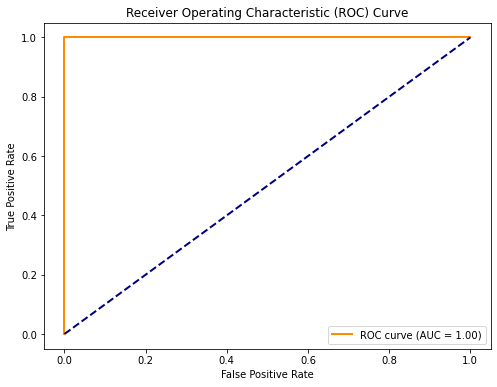

 Monk:                     2
 Trial:                    1
 Hyperparameters:          {'input_units': 17, 'hidden_units': 3, 'patience': 100, 'factor_lr_dec': 0.5, 'step_decay': 500, 'learning_rate': 0.21, 'batch_size': 30, 'epochs': 270, 'momentum': 0.5, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.06516014821827412
 Mean Validation Loss:     0.10439380668103695
 Test Loss:                0.08340787142515182
 Mean Training Accuracy:   0.9540958642959595
 Mean Validation Accuracy: 0.8871657729148865
 Test Accuracy:            0.9050925970077515
 f1 score:                 0.8628762541806021
 f2 score:                 0.8896551724137931
 Precision score:         0.821656050955414
 Recall score:             0.9084507042253521

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                262                 28
Real_Class_1                 13                129


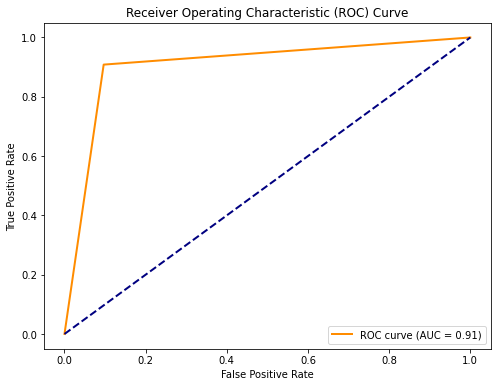

 Monk:                     3
 Trial:                    19
 Hyperparameters:          {'input_units': 17, 'hidden_units': 2, 'patience': 10, 'factor_lr_dec': 0.5, 'step_decay': 1000, 'learning_rate': 0.08, 'batch_size': 9, 'epochs': 380, 'weight_decay': 0.003, 'momentum': 0.075, 'nesterov': 'T', 'activation': 'tanh', 'output_activation': 'sigmoid', 'metrics': 'accuracy'}
 Mean Training Loss:       0.06171839609742165
 Mean Validation Loss:     0.08560437485575675
 Test Loss:                0.061076924204826355
 Mean Training Accuracy:   0.9507889866828918
 Mean Validation Accuracy: 0.934333324432373
 Test Accuracy:            0.9629629850387573
 f1 score:                 0.9636363636363636
 f2 score:                 0.9430604982206405
 Precision score:         1.0
 Recall score:             0.9298245614035088

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                204                  0
Real_Class_1                 16                212


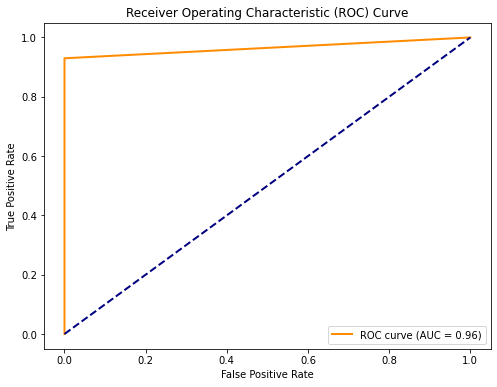

In [9]:

# Evaluation of the Models for each Test set
for dataset_i in range(datasets_number):
    X = x_test[dataset_i].values
    y = y_test[dataset_i].values

    # Evaluate the Model on TS set
    nn[dataset_i].test(
        x_test=X,
        y_test=y
    )

    # Computes the score of the Model
    nn[dataset_i].score(x_test=X, y_test=y)

    # Prints the results obtained
    print(nn[dataset_i])
    nn[dataset_i].print_confusion_matrix(y_test=y)
    nn[dataset_i].print_roc_curve(y_test=y)


